In [1]:
%matplotlib inline
import tables
import numpy
import os
import datetime
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib

import glob
import sys
import matplotlib.gridspec as gridspec
import CalculateMeanWinds
from scipy import signal


In [2]:
def readafile(fname):
    '''
    Function written by nicolls to read
    '''
    h5file=tables.open_file(fname)
    output={}
    for group in h5file.walk_groups("/"):
        output[group._v_pathname]={}
        for array in h5file.list_nodes(group, classname = 'Array'):
            output[group._v_pathname][array.name]=array.read()
    h5file.close()

    return output

def WeightedMeanNaN(x, dx):
    xdx = x/dx
    # bevington 4.17
    weightedMean = numpy.nansum(x/(dx**2), axis=0)/numpy.nansum(1./dx**2, axis=0)
    # bevington 4.19
    weightedVar = 1./numpy.nansum((1./dx**2), axis=0)
    weightedStd = numpy.sqrt(weightedVar)
    n = [numpy.where(numpy.isfinite(xdx[:,i]))[0].shape[0] for i in range(xdx.shape[1])]
    # print n
    return weightedMean, weightedStd, n

In [3]:
def PlotWindsvFlowVAltitude(inDict,KeySelect, outfile):
    """
    This function is primarily to plot the mean winds for each altitude as a function of year.
    This accepts a single dictionary in
    
    Taking out the 92.5 km altitude bin
    """
    nrow = 8
    ncol = 2
    # with PdfPages(outFile) as pdf:
    totalNumPlots = nrow*ncol

    f = plt.figure(dpi=300,figsize=(6,8))
    gs = gridspec.GridSpec(nrow, ncol)
    ialt = 8 # sets the altitude we are interested in
    iplot2 = 8
    iloc = 1
    
    keyList = sorted(inDict.keys())
    print keyList
    
    ikey = 0
    irow = 0
    
    tmpKey = inDict.keys()
    nshape = inDict[tmpKey[0]]['ut']['DecimalHoursTimeGrid'].shape[0]
    
#     colors = plt.cm.gist_rainbow(numpy.linspace(0,1,len(keyList)))
    colors = plt.cm.brg(numpy.linspace(0,1,len(keyList)))
    for irow in range(1,8,1):
        AvMeridWind = numpy.zeros([nshape,len(keyList)])
        AvZonalWind = numpy.zeros([nshape,len(keyList)])
        AvZonalFlow = numpy.zeros([nshape,len(keyList)])
        AvMeridFlow = numpy.zeros([nshape,len(keyList)])
        for ikey in range(len(keyList)):
            mltTimeDict = inDict[keyList[ikey]][KeySelect]
            ax00 = plt.subplot(gs[0,0])
            ax00.plot(mltTimeDict['DecimalHoursTimeGrid'], mltTimeDict['MeanZonalFlow'][1,:], color=colors[ikey])
            AvZonalFlow[:,ikey] = mltTimeDict['MeanZonalFlow'][1,:]
            ax00.set_ylim([-500,500])
            ax00.set_yticks(numpy.arange(-250,500,250))
            ax00.set_xticks(numpy.arange(0,26,3))
            ax00.set_xlim([0,24])
            ax00.xaxis.set_ticklabels([])
            ax00.grid()
            ax00.set_title('Zonal')
            ax00.set_ylabel('Ions (m/s)', fontsize=10)
#             ax00.set_xlabel(None)

            ax01 = plt.subplot(gs[0,1])
            if irow == 1:
                ax01.plot(mltTimeDict['DecimalHoursTimeGrid'], mltTimeDict['MeanMeridFlow'][1,:], color=colors[ikey],label='%s'%keyList[ikey][0:4])
            else:
                ax01.plot(mltTimeDict['DecimalHoursTimeGrid'], mltTimeDict['MeanMeridFlow'][1,:], color=colors[ikey])
            AvMeridFlow[:,ikey] = mltTimeDict['MeanMeridFlow'][1,:]
            ax01.set_ylim([-500,500])
            ax01.set_yticks(numpy.arange(-250,500,250))
            ax01.set_xticks(numpy.arange(0,26,3))
            ax01.set_xlim([0,24])
            ax01.xaxis.set_ticklabels([])
            ax01.grid()
            ax01.set_title('Meridional')
            ax01.yaxis.set_ticklabels([])
#             ax01.set_xlabel(None)
            

            # now do the winds
            ax1 = plt.subplot(gs[irow,0]) # plot winds
            ax1.plot(mltTimeDict['DecimalHoursTimeGrid'], mltTimeDict['MeanZonalWinds'][0,:,ialt], color=colors[ikey])
            ax1.set_ylabel(r'%0.1f km'%mltTimeDict['MeanAltitude'][ialt]+'\n'+'(m/s)', fontsize=10)
            ax1.set_ylim([-200,200])
            ax1.set_yticks([-100,0,100])
            AvZonalWind[:,ikey] = mltTimeDict['MeanZonalWinds'][0,:,ialt]
            ax1.set_xticks(numpy.arange(0,26,3))
            timeLbl = ['%02d'%i for i in numpy.arange(0,26,3)]
            ax1.set_xticklabels(timeLbl)
            ax1.set_xlim([0,24])
            if irow != 7:
                ax1.xaxis.set_ticklabels([])
            else:
                ax1.set_xlabel('MLT (Dec. Hrs)')
            ax1.grid()
#             ax1.set_xlabel(None)
        

            ax2 = plt.subplot(gs[irow,1])
            ax2.plot(mltTimeDict['DecimalHoursTimeGrid'], mltTimeDict['MeanMeridWinds'][0,:,ialt], color=colors[ikey])
            AvMeridWind[:,ikey] = mltTimeDict['MeanMeridWinds'][0,:,ialt]
            ax2.set_yticks([-100,0,100])
            ax2.set_ylim([-200,200])
            ax2.set_xticks(numpy.arange(0,26,3))
            timeLbl = ['%02d'%i for i in numpy.arange(0,26,3)]
            ax2.set_xticklabels(timeLbl)
            ax2.set_xlim([0,24])
            if irow != 7:
                ax2.xaxis.set_ticklabels([])
            else:
                ax2.set_xlabel('MLT (Dec. Hrs)')
#             ax2.xaxis.set_ticklabels([])
            
            ax2.yaxis.set_ticklabels([])
            ax2.grid()
#             ax2.set_xlabel(None)
#             print 'ikey', ikey
            ikey=ikey+1
        
        ax00.plot(mltTimeDict['DecimalHoursTimeGrid'], numpy.nanmean(AvZonalFlow, axis=1), 'k-', lw=2)
        ax01.plot(mltTimeDict['DecimalHoursTimeGrid'], numpy.nanmean(AvMeridFlow, axis=1), 'k-', lw=2)
        ax1.plot(mltTimeDict['DecimalHoursTimeGrid'], numpy.nanmean(AvZonalWind,axis=1), 'k-', lw=2)
        ax2.plot(mltTimeDict['DecimalHoursTimeGrid'], numpy.nanmean(AvMeridWind,axis=1), 'k-', lw=2)
        
        ax00.plot(mltTimeDict['DecimalHoursTimeGrid'], numpy.zeros(mltTimeDict['DecimalHoursTimeGrid'].shape[0]), 'k--', lw=2)
        ax01.plot(mltTimeDict['DecimalHoursTimeGrid'], numpy.zeros(mltTimeDict['DecimalHoursTimeGrid'].shape[0]), 'k--', lw=2)
        ax1.plot(mltTimeDict['DecimalHoursTimeGrid'],numpy.zeros(mltTimeDict['DecimalHoursTimeGrid'].shape[0]), 'k--', lw=2)
        ax2.plot(mltTimeDict['DecimalHoursTimeGrid'], numpy.zeros(mltTimeDict['DecimalHoursTimeGrid'].shape[0]), 'k--', lw=2)
        
        
#         ax00.grid()
#         ax01.grid()
#         ax1.grid()
#         ax2.grid()


        
        ialt=ialt-1
    
    
        
        
    

            
        
        

    #             ax[irow,icol].set_xlabel('Mean: %0.1f, Median: %0.1f'%(MeanX,MedianX))
                        # print numpy.nanmax(Uprime), numpy.nanmax(Vprime)
                        # if (irow == nrow-1) and (icol == ncol-1):
                        # ax[irow,icol].quiver([numpy.pi], [0.8], [100.], [0.], color='r')
                        # iplot+=1
    #             title = '%s - %s \n Red = Neutral Winds, Blue=Plasma Flow in Fregion'%(plottingOpts['yrmonStr'],plottingOpts['xlabels'])
    #             ax.set_title(title, fontsize=10)
    handles, labels = ax01.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center')
    ax01.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(outfile)

# Making the Main Figure

In [4]:

# this is the config file for the paper - 02212019
configfile = 'ConfigFileForPaper_02212019.ini'
CalcMeanWinds = CalculateMeanWinds.CalculateMeanWinds(configfile)

2019-03-15 16:02:15 - tools.configreader.ConfigReader - DEBUG: ConfigReader class initialized
2019-03-15 16:02:15 - tools.configreader.ConfigReader - DEBUG: No DEFAULT section found in ConfigFileForPaper_02212019.ini, ignoring...
2019-03-15 16:02:15 - tools.configreader.ConfigReader - DEBUG: 	[DATADISCARD]
2019-03-15 16:02:15 - tools.configreader.ConfigReader - DEBUG: 		ZonalWindMax : 500.0
2019-03-15 16:02:15 - tools.configreader.ConfigReader - DEBUG: 		ZonalWindMin : -500.0
2019-03-15 16:02:15 - tools.configreader.ConfigReader - DEBUG: 		MeridWindMax : 500.0
2019-03-15 16:02:15 - tools.configreader.ConfigReader - DEBUG: 		MeridWindMin : -500.0
2019-03-15 16:02:15 - tools.configreader.ConfigReader - DEBUG: 		ErrorZonalWind : 500.0
2019-03-15 16:02:15 - tools.configreader.ConfigReader - DEBUG: 		ErrorMeridWind : 500.0
2019-03-15 16:02:15 - tools.configreader.ConfigReader - DEBUG: 		NeMean : 10000000000.0
2019-03-15 16:02:15 - tools.configreader.ConfigReader - DEBUG: 	[TIME]
2019-03-15 

fname /Users/srkaeppler/Dropbox/research/data/NSF_PFISR_Eregion_NeutralWinds_SharedData/v0.4.5.2018.11.20/MonthlyWinds/201006_Winds.v0.4.5.2018.11.20.h5
[    0     1     2 ... 76731 76732 76733]
nnan raw (array([    0,     1,     2, ..., 76731, 76732, 76733]),)
[nan nan nan ... nan nan nan]
[-4.73582518e+01 -1.02229538e+02 -3.07717904e+01 ...  4.17631070e-01
 -3.75202062e-02 -3.17541989e-01]
Total starting Data, 76734 76734
nUsableInital, nNan 62856.0 13878.0
alt, initial usable data 82.5 5132.0 (5481,)
alt, initial usable data 87.5 5132.0 (5481,)
alt, initial usable data 92.5 5132.0 (5481,)
alt, initial usable data 97.5 5132.0 (5481,)
alt, initial usable data 102.5 5132.0 (5481,)
alt, initial usable data 107.5 5132.0 (5481,)
alt, initial usable data 112.5 5132.0 (5481,)
alt, initial usable data 117.5 5132.0 (5481,)
alt, initial usable data 122.5 5132.0 (5481,)
alt, initial usable data 127.5 5132.0 (5481,)
alt, initial usable data 132.5 1124.0 (5481,)
alt, initial usable data 137.5 513

CalculateMeanWinds.py:400: RuntimeWarning: invalid value encountered in less
  (InternalDict['NeMean'] < self.config['DATADISCARD']['NeMean']) \
CalculateMeanWinds.py:457: RuntimeWarning: Mean of empty slice
  MeanTime=numpy.nanmean(InternalDict['time'],axis=1)
CalculateMeanWinds.py:63: RuntimeWarning: invalid value encountered in divide
  weightedMean = numpy.nansum(x/(dx**2), axis=0)/numpy.nansum(1./dx**2, axis=0)
CalculateMeanWinds.py:65: RuntimeWarning: divide by zero encountered in divide
  weightedVar = 1./numpy.nansum((1./dx**2), axis=0)
CalculateMeanWinds.py:164: RuntimeWarning: Mean of empty slice
  MeanZonalWinds[1,itime,:] = numpy.nanmean(ZonalWind[qtime,:], axis=0)
/Users/srkaeppler/Env/EregWinds/lib/python2.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Users/srkaeppler/Env/EregWinds/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=k

fname /Users/srkaeppler/Dropbox/research/data/NSF_PFISR_Eregion_NeutralWinds_SharedData/v0.4.5.2018.11.20/MonthlyWinds/201106_Winds.v0.4.5.2018.11.20.h5
[   10    12    24 ... 86769 86770 86771]
nnan raw (array([   10,    12,    24, ..., 86769, 86770, 86771]),)
[nan nan nan ... nan nan nan]
[-5.70741558e+02  6.25952667e+01 -1.63914718e+01 ... -2.05719607e+02
 -4.89488523e-01  5.15462557e-01]
Total starting Data, 86772 86772
nUsableInital, nNan 74587.0 12185.0
alt, initial usable data 82.5 6141.0 (6198,)
alt, initial usable data 87.5 6141.0 (6198,)
alt, initial usable data 92.5 6141.0 (6198,)
alt, initial usable data 97.5 6141.0 (6198,)
alt, initial usable data 102.5 6141.0 (6198,)
alt, initial usable data 107.5 6141.0 (6198,)
alt, initial usable data 112.5 6141.0 (6198,)
alt, initial usable data 117.5 6141.0 (6198,)
alt, initial usable data 122.5 6141.0 (6198,)
alt, initial usable data 127.5 6141.0 (6198,)
alt, initial usable data 132.5 895.0 (6198,)
alt, initial usable data 137.5 6141

fname /Users/srkaeppler/Dropbox/research/data/NSF_PFISR_Eregion_NeutralWinds_SharedData/v0.4.5.2018.11.20/MonthlyWinds/201506_Winds.v0.4.5.2018.11.20.h5
[  2936   2938   2950 ... 107377 107378 107379]
nnan raw (array([  2936,   2938,   2950, ..., 107377, 107378, 107379]),)
[nan nan nan ... nan nan nan]
[ 5.11934766e+02  1.02820962e+03 -4.65766881e+02 ...  1.30505317e+01
 -1.36823326e-02 -5.68517695e-05]
Total starting Data, 107380 107380
nUsableInital, nNan 96796.0 10584.0
alt, initial usable data 82.5 7668.0 (7670,)
alt, initial usable data 87.5 7668.0 (7670,)
alt, initial usable data 92.5 7668.0 (7670,)
alt, initial usable data 97.5 7668.0 (7670,)
alt, initial usable data 102.5 7668.0 (7670,)
alt, initial usable data 107.5 7668.0 (7670,)
alt, initial usable data 112.5 7668.0 (7670,)
alt, initial usable data 117.5 7668.0 (7670,)
alt, initial usable data 122.5 7668.0 (7670,)
alt, initial usable data 127.5 7668.0 (7670,)
alt, initial usable data 132.5 2390.0 (7670,)
alt, initial usable 

/Users/srkaeppler/Env/EregWinds/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/srkaeppler/Env/EregWinds/lib/python2.7/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '


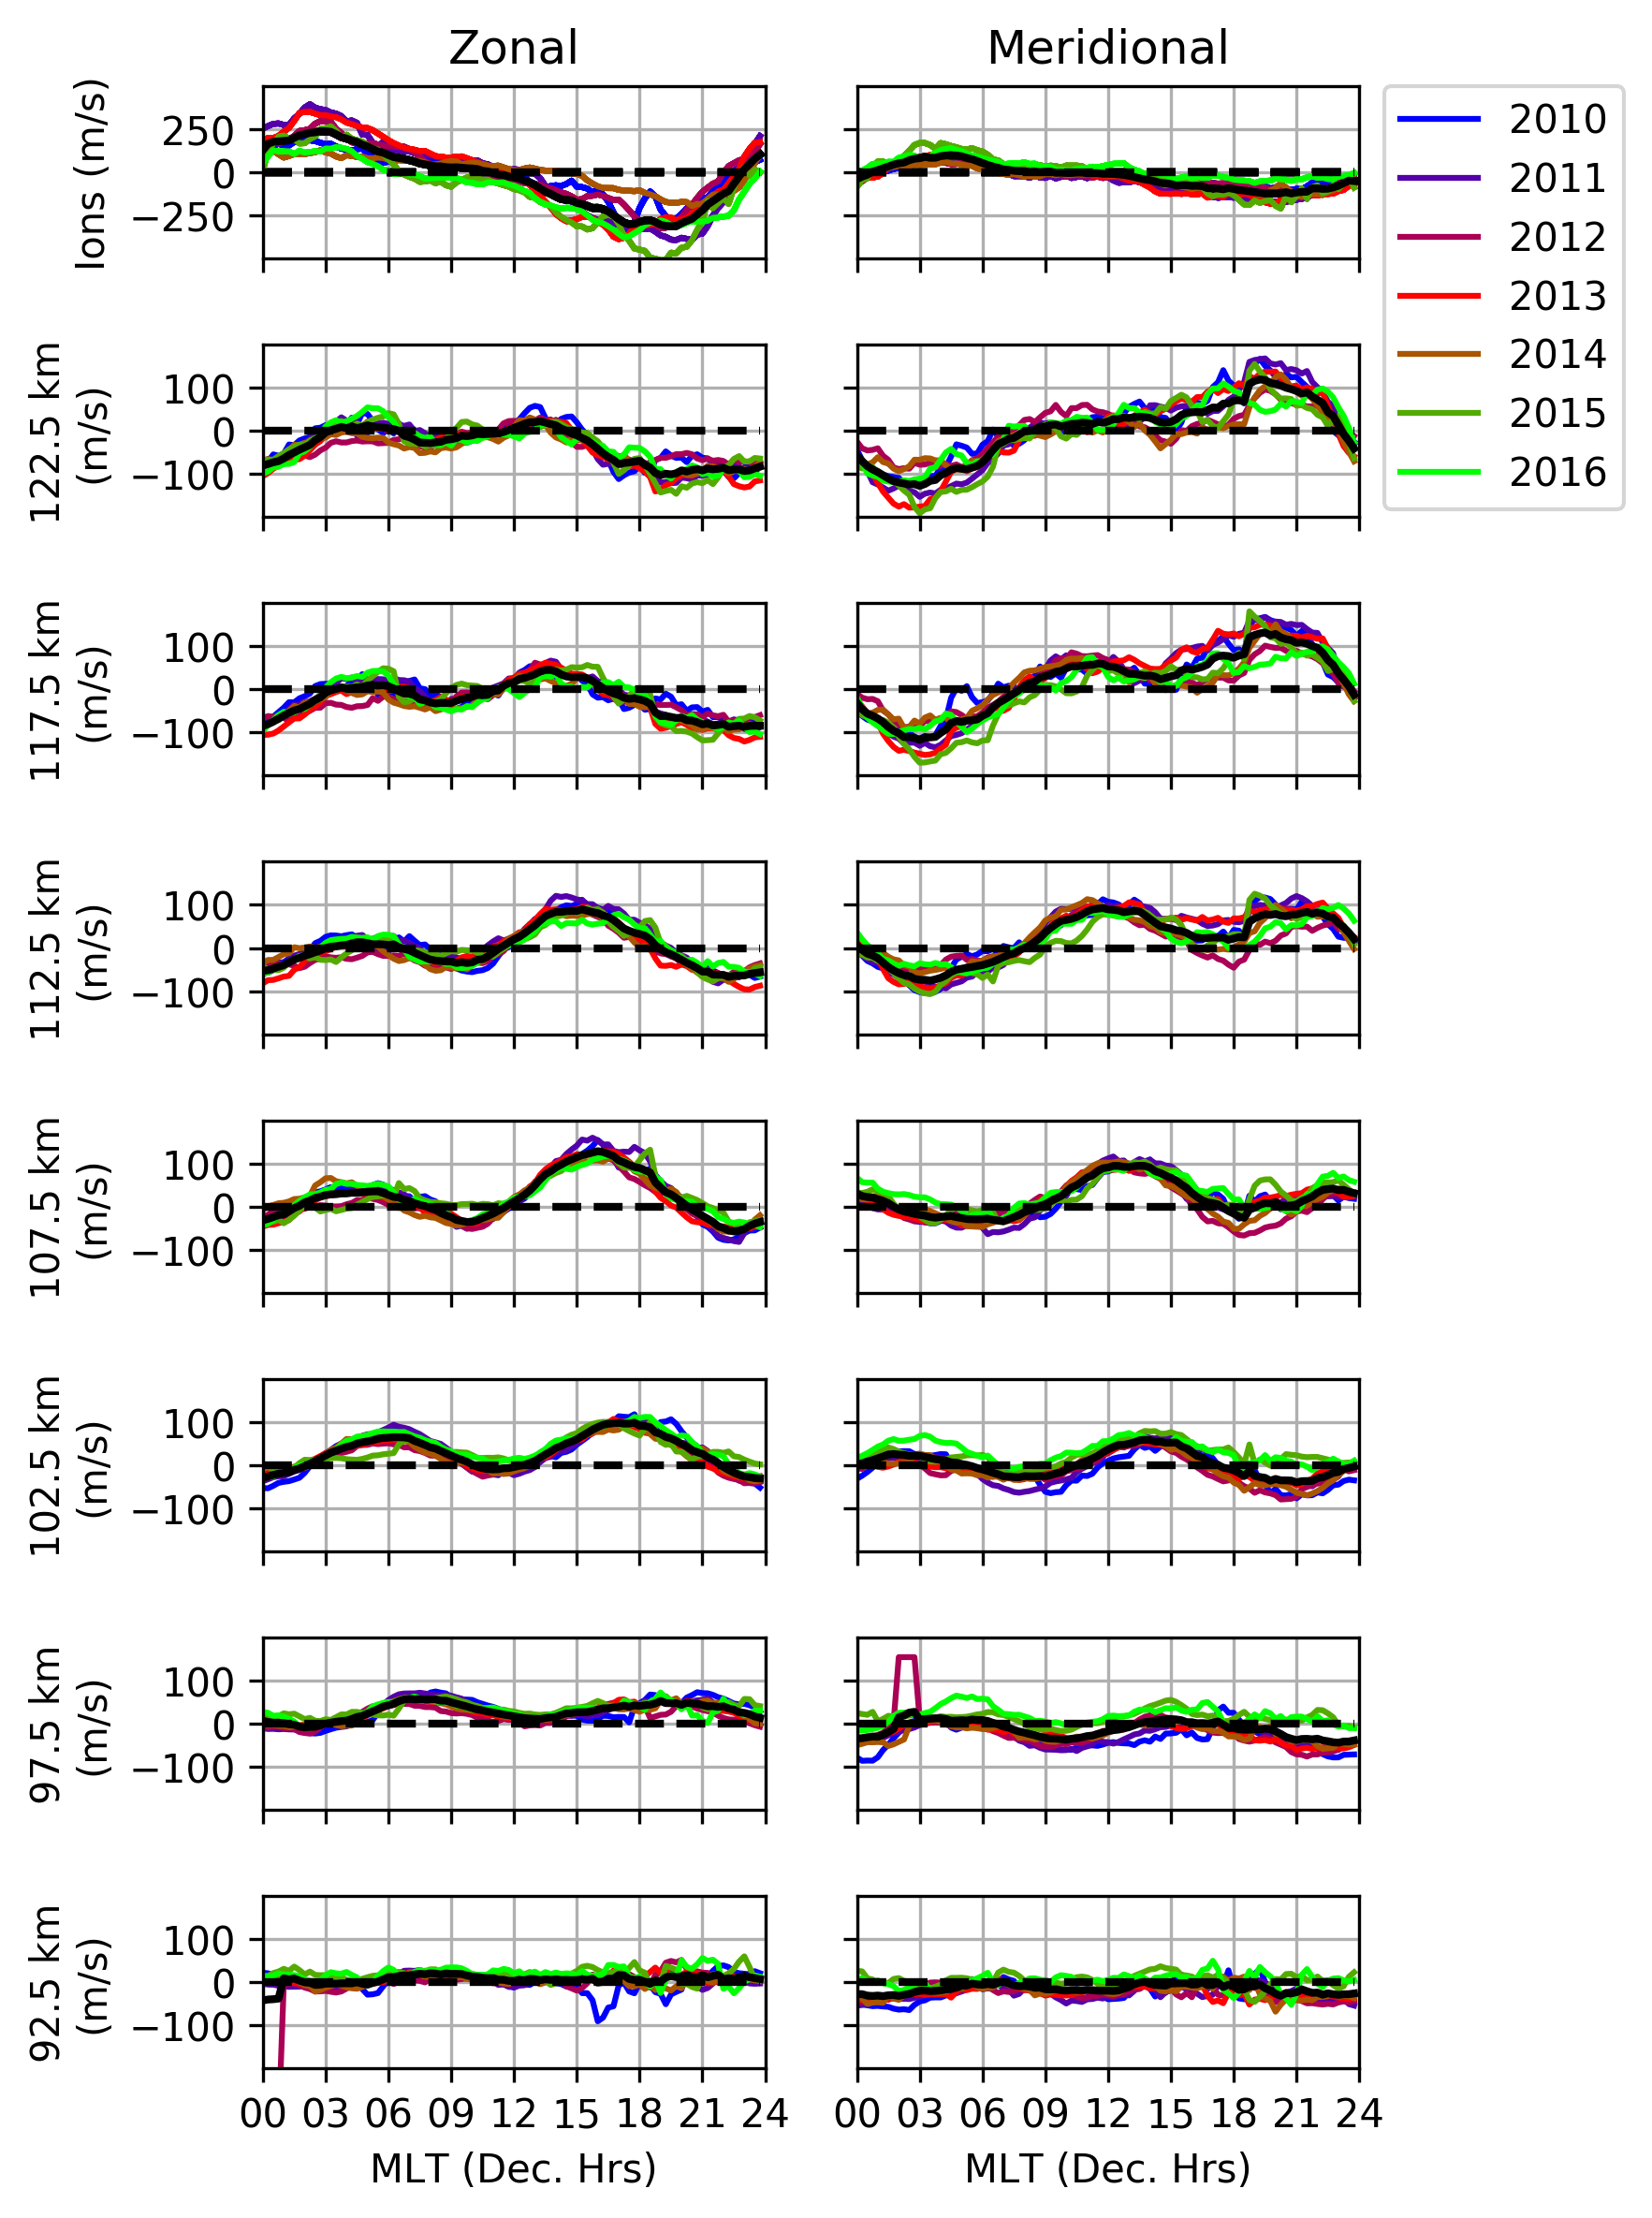

In [5]:


fnames = ['/Users/srkaeppler/Dropbox/research/data/NSF_PFISR_Eregion_NeutralWinds_SharedData/v0.4.5.2018.11.20/MonthlyWinds/201006_Winds.v0.4.5.2018.11.20.h5',
            '/Users/srkaeppler/Dropbox/research/data/NSF_PFISR_Eregion_NeutralWinds_SharedData/v0.4.5.2018.11.20/MonthlyWinds/201106_Winds.v0.4.5.2018.11.20.h5',
           '/Users/srkaeppler/Dropbox/research/data/NSF_PFISR_Eregion_NeutralWinds_SharedData/v0.4.5.2018.11.20/MonthlyWinds/201206_Winds.v0.4.5.2018.11.20.h5',
          '/Users/srkaeppler/Dropbox/research/data/NSF_PFISR_Eregion_NeutralWinds_SharedData/v0.4.5.2018.11.20/MonthlyWinds/201306_Winds.v0.4.5.2018.11.20.h5',
            '/Users/srkaeppler/Dropbox/research/data/NSF_PFISR_Eregion_NeutralWinds_SharedData/v0.4.5.2018.11.20/MonthlyWinds/201406_Winds.v0.4.5.2018.11.20.h5',
         '/Users/srkaeppler/Dropbox/research/data/NSF_PFISR_Eregion_NeutralWinds_SharedData/v0.4.5.2018.11.20/MonthlyWinds/201506_Winds.v0.4.5.2018.11.20.h5',
         '/Users/srkaeppler/Dropbox/research/data/NSF_PFISR_Eregion_NeutralWinds_SharedData/v0.4.5.2018.11.20/MonthlyWinds/201606_Winds.v0.4.5.2018.11.20.h5',
         ]


# TmpDict = MakeDictionaryList(fnames)
TmpDict = CalcMeanWinds.main(fnames)
PlotWindsvFlowVAltitude(TmpDict,'mlt', './MeanWindsVYear.pdf')